In [1]:
import numpy as np
import os
import argparse
import time
import math
import random
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import gzip
import pickle5 as pickle
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsnooper

from tqdm import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#This function gets the false positive rate, true positive rate, cutting threshold and area under curve using the given signal and background array
def get_roc(sig,bkg):
    testY = np.array([1]*len(sig) + [0]*len(bkg))
    predY = np.array(sig+bkg)
    auc = roc_auc_score(testY, predY)
    fpr, tpr, thr = roc_curve(testY, predY)
    return fpr,tpr,thr,auc

In [15]:
class DetectorDataset(Dataset):

    def __init__(self,dsize=-1):
        
        DEP_dict = self.event_loader("DEP_P42575A.pickle")
        SEP_dict = self.event_loader("SEP_P42575A.pickle")

        if dsize == -1:
            dsize = min(len(DEP_dict), len(SEP_dict))
        
        #Shuffle dataset and select #dsize event from DEP and SEP
        np.random.shuffle(DEP_dict)
        np.random.shuffle(SEP_dict)
        DEP_dict = DEP_dict[:dsize]
        SEP_dict = SEP_dict[:dsize]
        self.event_dict = DEP_dict + SEP_dict
        self.label = ([1]*len(DEP_dict)) + ([0] * len(SEP_dict))
        
        self.size = len(self.event_dict)
        print(self.size)
        
        #Get offset values:
        self.max_offset = np.max(self.get_field_from_dict(DEP_dict,"tstart") + self.get_field_from_dict(SEP_dict,"tstart"))
        
        #Get all unique detector name:
        self.detector_name = np.unique(self.get_field_from_dict(DEP_dict,"detector") + self.get_field_from_dict(SEP_dict,"detector"))
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        event = self.event_dict[idx]
        wf = np.array(event["wf"])
        
        #Correct for tOffset:
        offset = self.max_offset - event["tstart"]
        initial_count = int(offset/event["period"])
        #Making sure all waveforms are of the same size of 3000 by cropping off the tail
        final_count = 3000 + initial_count
        wf = wf[initial_count:final_count]
        
        
        #Normalize WF
        wf -= np.average(wf[:100]) #Baseline subtraction using the first 100 samples
        wf /= np.max(wf) #normalize waveform to an amplitude of 1.0
        
        avse = event["avse"]
        tdrift = event["tDrift"]
        
        return wf, self.label[idx], avse
        
    def return_label(self):
        return self.trainY

    def return_detector_array(self):
        return self.detector_name
    
    #Load event from .pickle file
    def event_loader(self, address):
        wf_list = []
        with (open(address, "rb")) as openfile:
            while True:
#                 if len(wf_list) > 2000:
#                     break
                try:
                   wf_list.append(pickle.load(openfile, encoding='latin1'))
                except EOFError:
                    break
        return wf_list
    
    def get_field_from_dict(self, input_dict, fieldname):
        field_list = []
        for event in input_dict:
            field_list.append(event[fieldname])
        return field_list
    
    def plot_offset_correction(self):
        plt.subplot(211)
        
        plt.subplot(212)

In [16]:
#Load dataset
def load_data(batch_size):

    dataset = DetectorDataset()
    validation_split = .3 #Split data set into training & testing with 7:3 ratio
    shuffle_dataset = True
    random_seed= 42222

    #make sure we have the same amount of signal/bkg in the training/test dataset
    division = 2
    dataset_size = int(len(dataset)/division)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_indices += list(division*dataset_size - 1-np.array(train_indices))
    val_indices += list(division*dataset_size- 1-np.array(val_indices))

    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = data_utils.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=batch_size,sampler=valid_sampler,  drop_last=True)

    return train_loader,test_loader, dataset.return_detector_array()

In [17]:
#The fully connected part of neural network
class FCNet(nn.Module):
    def __init__(self, last_unit):
        super(FCNet, self).__init__()
        
        fc1, fc2, fc3, fc4 = (512, 256, 96, 32)
        self.fcnet = nn.Sequential(
            torch.nn.Linear(fc1, fc2),
            torch.nn.BatchNorm1d(fc2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc2, fc3),
            torch.nn.BatchNorm1d(fc3),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc3, fc4),
            torch.nn.BatchNorm1d(fc4),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(fc4, last_unit),
        )
    def forward(self, x):
        return self.fcnet(x)

In [18]:
#The CNN based model:
class CNN(nn.Module):
    def __init__(self,detector_len):
        super(CNN, self).__init__()
    
        conv1, conv2, conv3, conv4 = (16,24,32,48)
        self.fcnet = FCNet(1)
        self.CNNBackbone = nn.Sequential(
            torch.nn.Conv1d(1,conv1,16),
            torch.nn.MaxPool1d(kernel_size=2),
            torch.nn.BatchNorm1d(conv1),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Conv1d(conv1,conv2,8),
            torch.nn.MaxPool1d(kernel_size=2),
            torch.nn.BatchNorm1d(conv2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Conv1d(conv2,conv3,4),
            torch.nn.MaxPool1d(kernel_size=2),
            torch.nn.BatchNorm1d(conv3),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.Conv1d(conv3,conv4,4),
            torch.nn.MaxPool1d(kernel_size=2),
            torch.nn.BatchNorm1d(conv4),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout()
        )
        self.fc1 = torch.nn.Linear(183*conv4, 512)
        self.detector_len = detector_len
    
    #@torchsnooper.snoop()
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.CNNBackbone(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fcnet(x)
#         x = torch.sigmoid(x)
        return x
    
    def get_detector_embedding(self):
        return self.embedding(torch.arange(self.detector_len).to(DEVICE))

In [19]:
#The RNN based model:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        feed_in_dim = 512
        self.seq_len = 1000
        self.seg = 3
        self.RNNLayer = torch.nn.GRU(input_size = self.seg, hidden_size = feed_in_dim//2, batch_first=True)
        self.fcnet = FCNet(1)
        self.attention_weight = Parameter(torch.empty(self.seq_len,feed_in_dim//2).uniform_(-0.1, 0.1))
        self.norm = torch.nn.BatchNorm1d(feed_in_dim)

    def forward(self, x):
        x = x.view(-1,self.seq_len,self.seg)
        output, hidden = self.RNNLayer(x)
        hidden =  hidden[-1]
        
        #Attention Mechanism
        hidden_attention = hidden.unsqueeze(1).expand(*output.size()) #[batch, 1, channel] -> [batch, seq_len, channel]
        w_attention = self.attention_weight.unsqueeze(0).expand(*output.size()) #[1, seq_len, channel] -> [batch, seq_len, channel]
        attention_score = torch.softmax(output * w_attention * hidden_attention,dim=1) #Softmax over seq_len dimension
        context = torch.sum(attention_score * output,dim=1) #Sum over seq_len dimension with attention score multiplied to output
        x = self.fcnet(torch.cat([context,hidden],dim=-1)) #concatenate context vector with last hidden state output

        return x

In [20]:
BATCH_SIZE = 32
train_loader, test_loader, det_array = load_data(BATCH_SIZE)

35636


In [21]:
#This feeds the waveform into classifier and get sigmoid output for signal and background events
def get_sigmoid(waveform_in, labels_in ,classifier_in):
    waveform_in = waveform_in.to(DEVICE)
    labels_in = labels_in.to(DEVICE).float()
    outputs_in  = classifier_in(waveform_in)

    lb_data_in = labels_in.cpu().data.numpy().flatten()
    outpt_data_in = outputs_in.cpu().data.numpy().flatten()

    signal_in = np.argwhere(lb_data_in == 1.0)
    bkg_in = np.argwhere(lb_data_in == 0.0)

    return list(outpt_data_in[signal_in].flatten()), list(outpt_data_in[bkg_in].flatten())

#params 617377


  1%|          | 4/334 [00:00<00:09, 36.51it/s]

Epoch [1/10], Iter [779/779] Loss: 0.6716

100%|██████████| 334/334 [00:09<00:00, 34.87it/s]
No handles with labels found to put in legend.


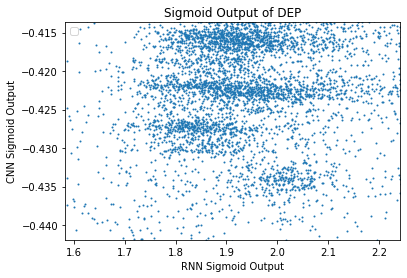

No handles with labels found to put in legend.


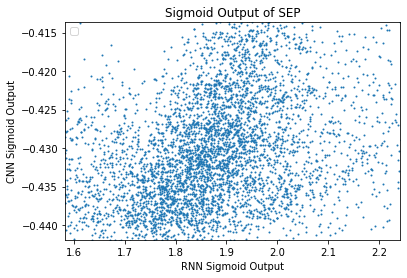

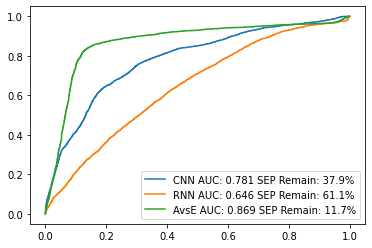

  1%|          | 4/334 [00:00<00:09, 36.06it/s]

Epoch [2/10], Iter [779/779] Loss: 0.6559

100%|██████████| 334/334 [00:09<00:00, 35.11it/s]
No handles with labels found to put in legend.


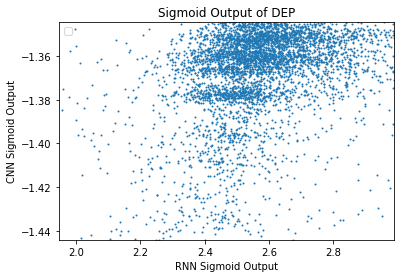

No handles with labels found to put in legend.


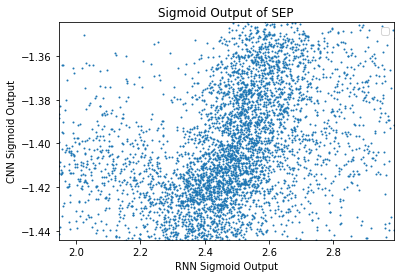

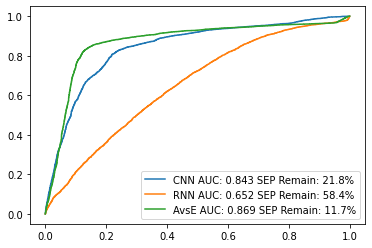

  1%|          | 4/334 [00:00<00:09, 35.62it/s]

Epoch [3/10], Iter [779/779] Loss: 0.6097

100%|██████████| 334/334 [00:09<00:00, 35.20it/s]
No handles with labels found to put in legend.


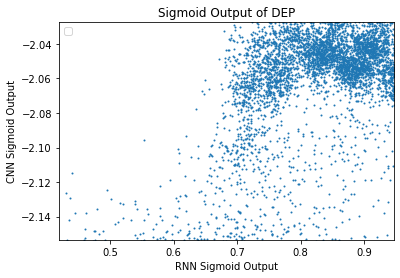

No handles with labels found to put in legend.


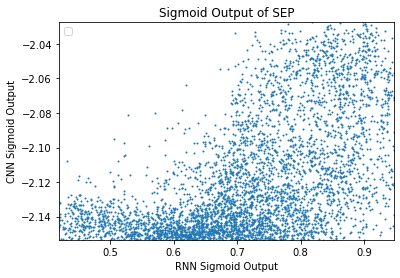

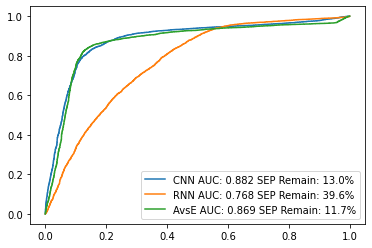

  1%|          | 4/334 [00:00<00:09, 33.06it/s]

Epoch [4/10], Iter [779/779] Loss: 0.4367

100%|██████████| 334/334 [00:09<00:00, 34.53it/s]
No handles with labels found to put in legend.


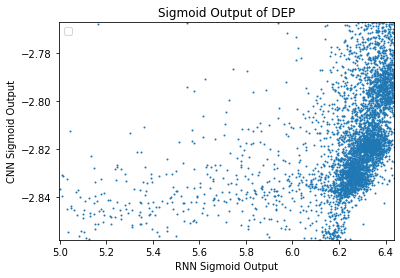

No handles with labels found to put in legend.


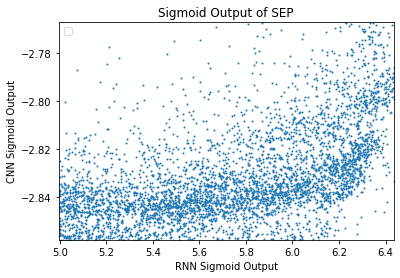

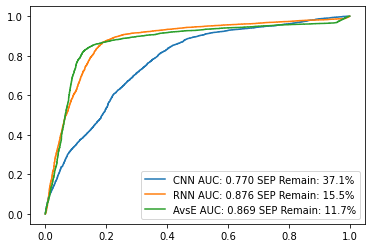

  1%|          | 4/334 [00:00<00:09, 33.64it/s]

Epoch [5/10], Iter [779/779] Loss: 0.3577

100%|██████████| 334/334 [00:10<00:00, 32.91it/s]
No handles with labels found to put in legend.


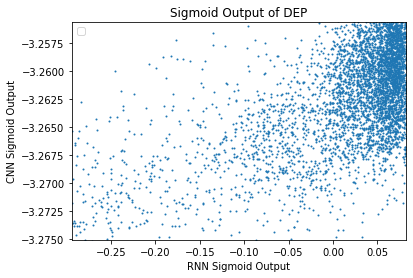

No handles with labels found to put in legend.


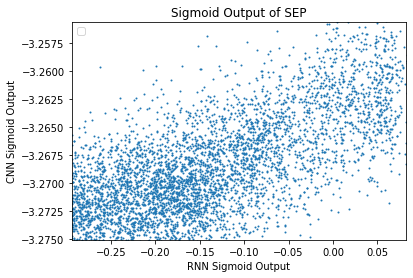

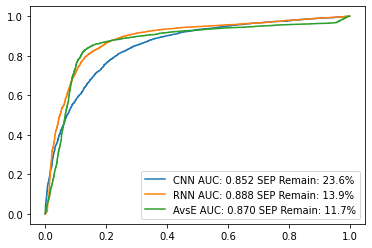

  1%|          | 4/334 [00:00<00:09, 36.32it/s]

Epoch [6/10], Iter [779/779] Loss: 0.1933

100%|██████████| 334/334 [00:09<00:00, 34.88it/s]
No handles with labels found to put in legend.


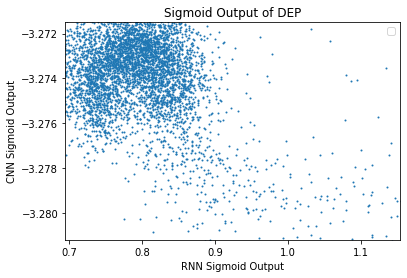

No handles with labels found to put in legend.


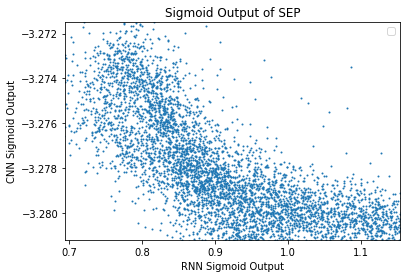

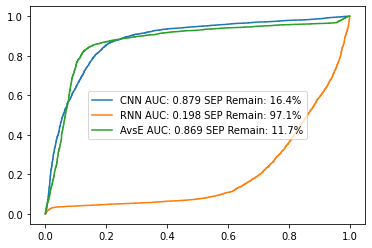

  1%|          | 4/334 [00:00<00:09, 36.09it/s]

Epoch [7/10], Iter [779/779] Loss: 0.3011

100%|██████████| 334/334 [00:09<00:00, 35.23it/s]
No handles with labels found to put in legend.


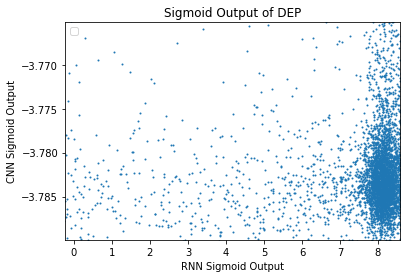

No handles with labels found to put in legend.


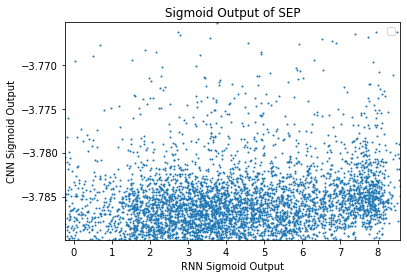

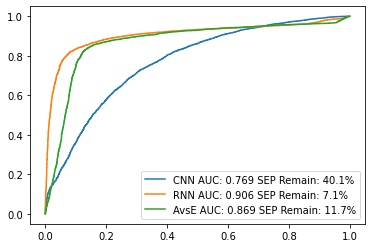

  1%|          | 4/334 [00:00<00:09, 35.13it/s]

Epoch [8/10], Iter [779/779] Loss: 0.2550

100%|██████████| 334/334 [00:09<00:00, 34.53it/s]
No handles with labels found to put in legend.


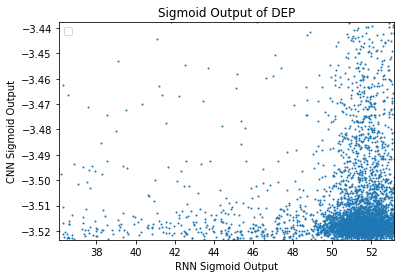

No handles with labels found to put in legend.


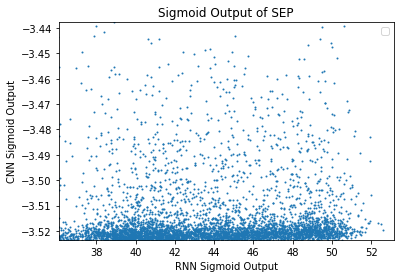

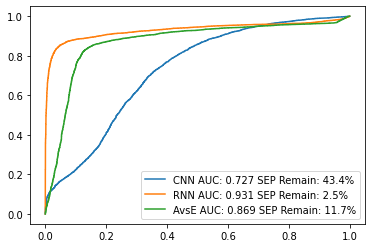

  1%|          | 4/334 [00:00<00:09, 35.84it/s]

Epoch [9/10], Iter [779/779] Loss: 0.1368

100%|██████████| 334/334 [00:10<00:00, 32.21it/s]
No handles with labels found to put in legend.


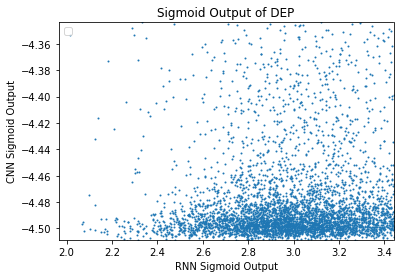

No handles with labels found to put in legend.


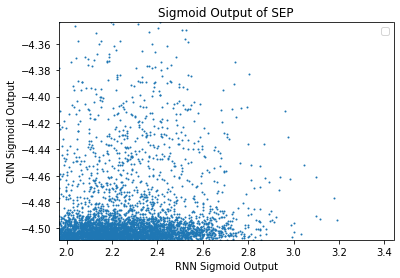

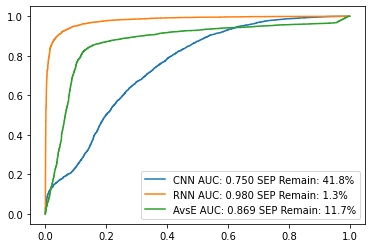

  1%|          | 4/334 [00:00<00:09, 35.66it/s]

Epoch [10/10], Iter [779/779] Loss: 0.2131

100%|██████████| 334/334 [00:09<00:00, 34.55it/s]
No handles with labels found to put in legend.


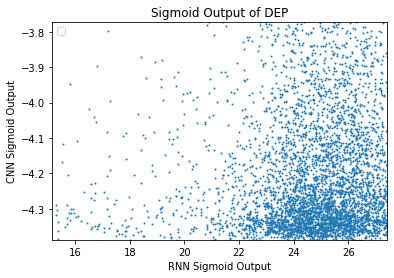

No handles with labels found to put in legend.


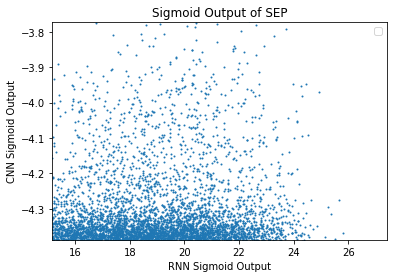

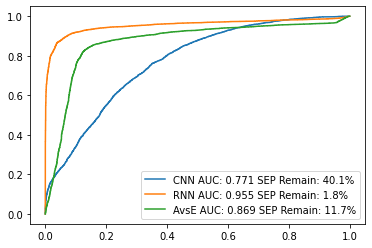

In [23]:
NUM_EPOCHS = 10
LEARNING_RATE =1*10**-4

#Define both CNN and RNN
RNNclassifier = RNN()
CNNclassifier = CNN(len(det_array))

RNNclassifier.to(DEVICE)
CNNclassifier.to(DEVICE)



print("#params", sum(x.numel() for x in RNNclassifier.parameters()))

RNNcriterion = torch.nn.BCEWithLogitsLoss() #BCEWithLogitsLoss does not require the last layer to be sigmoid
RNNcriterion = RNNcriterion.to(DEVICE)

CNNcriterion = torch.nn.BCEWithLogitsLoss()
CNNcriterion = CNNcriterion.to(DEVICE)

RNNoptimizer = torch.optim.AdamW(
    RNNclassifier.parameters(),
    lr=LEARNING_RATE)

CNNoptimizer = torch.optim.AdamW(
    CNNclassifier.parameters(),
    lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    for i, (waveform, labels, avse) in enumerate(train_loader):
        CNNclassifier.train()
        RNNclassifier.train()
        waveform = waveform.to(DEVICE)
        labels = labels.to(DEVICE).float()
        labels = labels.view(-1,1)
        
        #Train RNN
        RNNoutputs  = RNNclassifier(waveform)
        RNNloss = RNNcriterion(RNNoutputs, labels)
        
        #Train CNN
        CNNoutputs  = CNNclassifier(waveform)
        CNNloss = CNNcriterion(CNNoutputs, labels)

        CNNloss.backward()
        CNNoptimizer.step()        # update parameters of net
        CNNoptimizer.zero_grad()   # reset gradient
        
        RNNloss.backward()
        RNNoptimizer.step()        # update parameters of net
        RNNoptimizer.zero_grad()   # reset gradient

    print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        RNNloss.item(), end=""),end="")
    sigmoid_s_RNN = []
    sigmoid_b_RNN = []
    sigmoid_s_CNN = []
    sigmoid_b_CNN = []
    avse_s = []
    avse_b = []

    for waveform,labels,avse in tqdm(test_loader):

        CNNclassifier.eval()
        RNNclassifier.eval()

        with torch.no_grad():
            sig_CNN, bkg_CNN = get_sigmoid(waveform, labels, CNNclassifier)
            sig_RNN, bkg_RNN = get_sigmoid(waveform, labels, RNNclassifier)

            lb_data = labels.cpu().data.numpy().flatten()
            avse_data = avse.cpu().data.numpy().flatten()
            
            signal = np.argwhere(lb_data == 1.0)
            bkg = np.argwhere(lb_data == 0.0)
            
            sigmoid_s_RNN += sig_RNN
            sigmoid_b_RNN += bkg_RNN
            sigmoid_s_CNN += sig_CNN
            sigmoid_b_CNN += bkg_CNN
            
            avse_s += list(avse_data[signal].flatten())
            avse_b += list(avse_data[bkg].flatten())

    #Set the range of scatter plot from 5% to 95% quantile of sigmoid output
    xlow = np.quantile(sigmoid_s_RNN+sigmoid_b_RNN,0.05)
    xhi = np.quantile(sigmoid_s_RNN+sigmoid_b_RNN,0.95)
    ylow = np.quantile(sigmoid_s_CNN + sigmoid_b_CNN,0.05)
    yhi = np.quantile(sigmoid_s_CNN + sigmoid_b_CNN,0.95)

    #Plot sigmoid output for DEP events
    plt.scatter(sigmoid_s_RNN, sigmoid_s_CNN,s=1)
    plt.title("Sigmoid Output of DEP")
    plt.xlim(left=xlow, right=xhi)
    plt.ylim(bottom=ylow, top=yhi)
    plt.xlabel("RNN Sigmoid Output")
    plt.ylabel("CNN Sigmoid Output")
    plt.legend()
    plt.savefig("Sigmoid_signal.png",dpi=200)
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    #Plot sigmoid output for SEP events
    plt.scatter(sigmoid_b_RNN, sigmoid_b_CNN,s=1)
    plt.xlim(left=xlow, right=xhi)
    plt.ylim(bottom=ylow, top=yhi)
    plt.title("Sigmoid Output of SEP")
    plt.xlabel("RNN Sigmoid Output")
    plt.ylabel("CNN Sigmoid Output")
    plt.legend()
    plt.savefig("Sigmoid_bkg.png",dpi=200)
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    # Plot the ROC curve for CNN, RNN and AvsE
    fpr_cnn, tpr_cnn, thr_cnn, auc_cnn = get_roc(sigmoid_s_CNN, sigmoid_b_CNN)
    fpr_rnn, tpr_rnn, thr_rnn, auc_rnn = get_roc(sigmoid_s_RNN, sigmoid_b_RNN)
    fpr_avse, tpr_avse, thr_avse, auc_avse = get_roc(avse_s, avse_b)
    rej_tpr = tpr_avse[np.argmin(np.abs(thr_avse+1.0))]
    plt.plot(fpr_cnn,tpr_cnn,label="CNN AUC: %.3f SEP Remain: %.1f%%"%(auc_cnn, fpr_cnn[np.argmin(np.abs(tpr_cnn-rej_tpr))]*100.0))
    plt.plot(fpr_rnn,tpr_rnn,label="RNN AUC: %.3f SEP Remain: %.1f%%"%(auc_rnn,fpr_rnn[np.argmin(np.abs(tpr_rnn-rej_tpr))]*100.0))
    plt.plot(fpr_avse,tpr_avse,label="AvsE AUC: %.3f SEP Remain: %.1f%%"%(auc_avse,fpr_avse[np.argmin(np.abs(thr_avse+1.0))]*100.0))
    plt.legend()
    plt.savefig("ROC.png",dpi=200)
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()
    
    #Save CNN and RNN models.
    torch.save(CNNclassifier.state_dict(), 'CNN.pt')
    torch.save(RNNclassifier.state_dict(), 'RNN.pt')
    

No handles with labels found to put in legend.


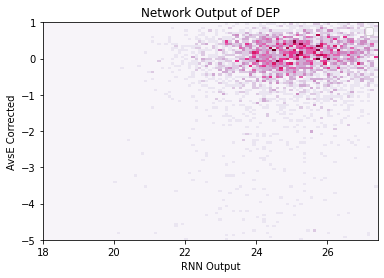

No handles with labels found to put in legend.


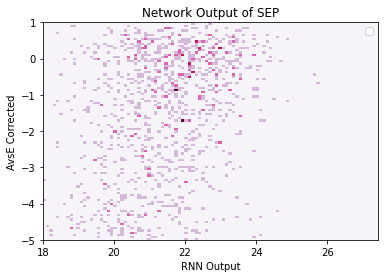

-4.340037 23.540808


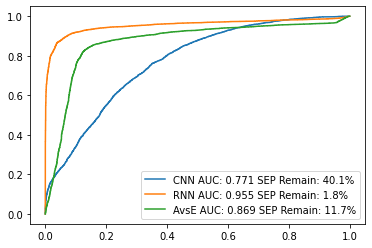

In [47]:
#Plotting confusion plot of A vs. E and RNN classifier
xlow = 18
xhi = np.quantile(sigmoid_s_RNN+sigmoid_b_RNN,0.95)
ylow = -5
yhi =1

#Plot sigmoid output for DEP events
plt.hist2d(sigmoid_s_RNN, avse_s,bins = (np.linspace(xlow,xhi,100),np.linspace(ylow,yhi,100)),cmap="PuRd")
plt.title("Network Output of DEP")
plt.xlabel("RNN Output")
plt.ylabel("AvsE Corrected")
plt.legend()
plt.savefig("AR_signal.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()

#Plot sigmoid output for SEP events
plt.hist2d(sigmoid_b_RNN, avse_b,bins = (np.linspace(xlow,xhi,100),np.linspace(ylow,yhi,100)),cmap="PuRd")
plt.title("Network Output of SEP")
plt.xlabel("RNN Output")
plt.ylabel("AvsE Corrected")
plt.legend()
plt.savefig("AR_bkg.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()

In [ ]:
#Plotting confusion plot of CNN and RNN classifier
xlow = np.quantile(sigmoid_s_RNN+sigmoid_b_RNN,0.01)
xhi = np.quantile(sigmoid_s_RNN+sigmoid_b_RNN,0.99)
ylow = np.quantile(sigmoid_s_CNN + sigmoid_b_CNN,0.01)
yhi = np.quantile(sigmoid_s_CNN + sigmoid_b_CNN,0.99)

#Plot sigmoid output for DEP events
plt.hist2d(sigmoid_s_RNN, sigmoid_s_CNN,bins = (np.linspace(xlow,xhi,100),np.linspace(ylow,yhi,100)),cmap="PuRd")
plt.title("Sigmoid Output of DEP")
plt.xlabel("RNN Output")
plt.ylabel("CNN Output")
plt.legend()
plt.savefig("Sigmoid_signal.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()

#Plot sigmoid output for SEP events
plt.hist2d(sigmoid_b_RNN, sigmoid_b_CNN,bins = (np.linspace(xlow,xhi,100),np.linspace(ylow,yhi,100)),cmap="PuRd")
plt.title("Sigmoid Output of SEP")
plt.xlabel("RNN Output")
plt.ylabel("CNN Output")
plt.legend()
plt.savefig("Sigmoid_bkg.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()

#Plot sigmoid output for DEP events
plt.hist(sigmoid_s_RNN, bins = np.linspace(xlow,xhi,100),color="red",histtype="step",label="DEP")
plt.hist(sigmoid_b_RNN, bins = np.linspace(xlow,xhi,100),color="blue",histtype="step",label="SEP")
plt.title("RNN output")
plt.xlabel("RNN Sigmoid Output")
plt.ylabel("RNN output")
plt.legend()
plt.savefig("RNN1d.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()

#Plot sigmoid output for SEP events
plt.hist(sigmoid_s_CNN, bins = np.linspace(ylow,yhi,100),color="red",histtype="step")
plt.hist(sigmoid_b_CNN, bins = np.linspace(ylow,yhi,100),color="blue",histtype="step")
plt.title("CNN output")
plt.xlabel("RNN Sigmoid Output")
plt.ylabel("CNN Sigmoid Output")
plt.legend()
plt.savefig("CNN1d.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()